In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
import numpy as np
import torch
import pickle
import itertools
import os
import random
import cv2
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
import tqdm
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, TensorDataset, DataLoader

print("Torch version:", torch.__version__)

assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

In [ ]:
import clip

clip.available_models()

In [5]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 112MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [6]:
# CLIP has some layers explicitly parameterized using fp16 values. We need to
# convert them back to fp32 in order to use automatic mixed-precision training
def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp32"""

    def _convert_weights_to_fp32(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.float()
            if l.bias is not None:
                l.bias.data = l.bias.data.float()

        if isinstance(l, nn.MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.float()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr = getattr(l, name)
                if attr is not None:
                    attr.data = attr.data.float()

    model.apply(_convert_weights_to_fp32)

convert_weights(model)

# Dataset Preprocessing

In [44]:
BASE_DIR = "/content/drive/MyDrive/coursework/mmml/DecorAssistant/dataset/"
DATASET_DIR = "/content/drive/MyDrive/coursework/mmml/DecorAssistant/dataset/text_data/"
IMAGES_DIR = "/content/drive/MyDrive/coursework/mmml/DecorAssistant/dataset/images/all_items/"
POSITIVE_SIZE = None # We might only use a subset of the positive pairs
TRAIN_TEST_RATIO = 0.33

In [38]:
def preprocess_img(path):
  img = cv2.imread(path)
  img = cv2.resize(img, (256, 256))
  img = img.astype(np.float32) / 255
  return img

def read_pickle(fn):
	with open(fn, "rb") as f:
		return pickle.load(f)

In [54]:
def random_negative_sampling(products, all_positive_pairs, count=None, random_state=None):
  selected_negative_pairs = []
  if random_state is not None: random.seed(random_state)
  while len(selected_negative_pairs) < (count or len(all_positive_pairs)):
    random_pair = tuple(random.sample(products, 2))
    if random_pair in all_positive_pairs:
      continue
    else:
      selected_negative_pairs.append(random_pair)
  return selected_negative_pairs
  
# {room image url -> string of room category}; e.g.: 'ikea-town-and-country__1364308377063-s4.jpg': 'Living Room'
room_categories = read_pickle(DATASET_DIR + "categories_dict.p")
# {item image ID -> string of item category}; e.g.: '291.292.29': 'Footstool',
item_categories = read_pickle(DATASET_DIR + "categories_images_dict.p")
# {item image id -> dict of descriptions}; e.g. '202.049.06': {'color': 'Grey,black','desc': 'View more product information Concealed press studs keep the quilt in place','img': 'images/objects/202.049.06.jpg','name': 'GURLI','size': '120x180 cm','type': 'Throw'},
item_property = read_pickle(DATASET_DIR + "products_dict.p")
# {item image url -> {description, name}}; e.g: '/static/images/902.592.50.jpg': {'desc': 'The high pile dampens sound and provides a soft surface to walk on.','name': 'GSER'},
item_to_description = read_pickle(DATASET_DIR + "img_to_desc.p")
# {item image url -> list of corresponding room image url}; e.g.: 'images/001.509.85.jpg': ['images/room_scenes/ikea-wake-up-and-grow__1364335362013-s4.jpg','images/room_scenes/ikea-wake-up-and-grow-1364335370196.jpg'],
item_to_rooms_map = read_pickle(DATASET_DIR + "item_to_room.p")
# {room image url -> list of items}; e.g.: 'ikea-work-from-home-in-perfect-harmony__1364319311386-s4.jpg': ['desk','chair']
room_to_item_categories = read_pickle(DATASET_DIR + "room_to_items.p")

# Some simple preprossing
item_to_info = {key : value["type"] + " " +
                             value["desc"]
                       for key, value in item_property.items()} # remove view more info

room_to_items = {}

for item_url, room_url_list in item_to_rooms_map.items():
  item_id = item_url.split("/")[-1].split(".jpg")[0]
  if not os.path.exists(IMAGES_DIR + item_id + ".jpg"):
      print(item_url + " does not exist")
      continue

  for room_url in room_url_list:
    room_id = room_url.split("/")[-1].split(".jpg")[0]
    if room_id not in room_to_items:
      room_to_items[room_id] = [item_id]
    else:
      room_to_items[room_id].append(item_id)

all_positive_pairs = set()
for room, item_id_list in room_to_items.items():
  pairs_for_current_room = list(itertools.combinations(room_to_items[room], 2)) # n choose 2
  all_positive_pairs |= set(pairs_for_current_room)

# if POSITIVE_SIZE is not None:
#     sampled_positives = all_positive_pairs[:POSITIVE_SIZE] # Uncomment to subsample
# else:
#     sampled_positives = all_positive_pairs
# all_pairs = sampled_positives + random_negative_sampling(all_positive_pairs, count=len(sampled_positives))
# y = np.array([1 for _ in range(len(all_positive_pairs))] + 
#              [0 for _ in range(len(all_positive_pairs))])
# train_pairs, val_pairs, y_train, y_val = train_test_split(all_pairs, y, test_size=TRAIN_TEST_RATIO, random_state=517)

# # Shuffle now so batches are not all positive or all negative
# train_indices = np.random.permutation(np.arange(len(train_pairs)))
# train_pairs = [train_pairs[i] for i in train_indices]
# y_train = y_train[train_indices]

# val_indices = np.random.permutation(np.arange(len(val_pairs)))
# val_pairs = [val_pairs[i] for i in val_indices]
# y_val = y_val[val_indices]

# len(train_pairs), len(val_pairs), y_train[:10], y_val[:10]

images/890.333.75.jpg does not exist
images/991.333.98.jpg does not exist
images/990.612.97.jpg does not exist


In [55]:
# Train-val split that does not share products between training and validation sets.
def generate_product_limited_samples(products, all_positive_pairs, random_state=None):
    """
    Generates positive and negative examples for the given products using shared
    occurence in rooms to indicate whether two products are compatible.

    products: A sequence of product IDs; ALL positive and negative pairs must
        contain only these product IDs.
    all_positive_pairs: A set of product ID pairs that are positive.
    
    Returns: A tuple (x, y), where x is a sequence of product ID pairs and y is
        the array of [0, 1] labels indicating presence in all_positive_pairs.
    """
    product_set = set(products)
    within_positive_pairs = [p for p in sorted(all_positive_pairs) if p[0] in product_set and p[1] in product_set]
    negative_pairs = random_negative_sampling(products, all_positive_pairs, count=len(within_positive_pairs), random_state=random_state)
    x = within_positive_pairs + negative_pairs
    y = np.array([1] * len(within_positive_pairs) + [0] * len(negative_pairs))
    if random_state is not None: np.random.seed(random_state)
    indices = np.random.permutation(np.arange(len(x)))
    return [x[i] for i in indices], y[indices]

all_products = sorted(set([x for pair in all_positive_pairs for x in pair]))
train_products, val_products = train_test_split(all_products, test_size=TRAIN_TEST_RATIO, random_state=517)

train_pairs, y_train = generate_product_limited_samples(train_products, all_positive_pairs, random_state=517)
val_pairs, y_val = generate_product_limited_samples(val_products, all_positive_pairs, random_state=517)
print(len(train_pairs), len(val_pairs))

with open(BASE_DIR + "train_data.pkl", "wb") as file:
    pickle.dump((train_pairs, y_train), file)
with open(BASE_DIR + "val_data.pkl", "wb") as file:
    pickle.dump((val_pairs, y_val), file)

22226 5384


In [56]:
# To read the training and validation sets
with open(BASE_DIR + "train_data.pkl", "rb") as file:
    train_pairs, y_train = pickle.load(file)
with open(BASE_DIR + "val_data.pkl", "rb") as file:
    val_pairs, y_val = pickle.load(file)

In [49]:
class FurnitureImagePairsDataset(Dataset):
    """Dataset containing pairs of furniture items."""

    def __init__(self, image_path, pairs, labels):
        """
        Args:
            image_path (string): Path to the directory containing images.
            pairs (list of tuples of strings): Pairs of image IDs to be used as training samples.
            labels (array of integers): Labels for the training samples.
        """
        super(FurnitureImagePairsDataset, self).__init__()
        self.image_ids = list(set(x for pair in pairs for x in pair))
        self.index_mapping = {image_id: i for i, image_id in enumerate(self.image_ids)}
        self.images = [preprocess(Image.open(image_path + image_id + ".jpg")) for image_id in tqdm.tqdm(self.image_ids)]
        self.pairs = pairs
        self.labels = labels

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if isinstance(idx, (list, tuple)):
            x1, x2, y = zip(*[self[i] for i in idx])
            return torch.stack(x1), torch.stack(x2), torch.from_numpy(np.array(y))

        pair = self.pairs[idx]
        return self.images[self.index_mapping[pair[0]]], self.images[self.index_mapping[pair[1]]], self.labels[idx]

In [ ]:
X_train_image = FurnitureImagePairsDataset(IMAGES_DIR, train_pairs, y_train)
X_val_image = FurnitureImagePairsDataset(IMAGES_DIR, val_pairs, y_val)

In [13]:
train_premise_texts = [item_to_info[id] for id, _ in train_pairs]
train_hypothesis_texts = [item_to_info[id] for _, id in train_pairs]
X_train_text_premise = clip.tokenize(train_premise_texts)
X_train_text_hypothesis = clip.tokenize(train_hypothesis_texts)

val_premise_texts = [item_to_info[id] for id, _ in val_pairs]
val_hypothesis_texts = [item_to_info[id] for _, id in val_pairs]
X_val_text_premise = clip.tokenize(val_premise_texts)
X_val_text_hypothesis = clip.tokenize(val_hypothesis_texts)

In [15]:
BATCH_SIZE = 32

img_train_data = X_train_image # TensorDataset(torch.from_numpy(X_train_image_premise), torch.from_numpy(X_train_image_hypothesis), torch.from_numpy(y_train))
text_train_data = TensorDataset(X_train_text_premise, X_train_text_hypothesis, torch.from_numpy(y_train))

img_val_data = X_val_image # TensorDataset(torch.from_numpy(X_val_image_premise), torch.from_numpy(X_val_image_hypothesis), torch.from_numpy(y_val))
text_val_data = TensorDataset(X_val_text_premise, X_val_text_hypothesis, torch.from_numpy(y_val))

text_train_loader = DataLoader(text_train_data, batch_size=BATCH_SIZE)
img_train_loader = DataLoader(img_train_data, batch_size=BATCH_SIZE)

text_val_loader = DataLoader(text_val_data, batch_size=BATCH_SIZE)
img_val_loader = DataLoader(img_val_data, batch_size=BATCH_SIZE)

print(len(text_train_loader), len(img_train_loader))
print(len(text_val_loader), len(img_val_loader))

838 838
413 413


In [ ]:
# Find out embedding shapes
print(model.encode_image(X_train_image[0][0][None,:].cuda()).size())
print(model.encode_text(X_train_text_premise[0:1].cuda()).size())

torch.Size([1, 512])
torch.Size([1, 512])


In [16]:
class CLIPIKEA(nn.Module):
    def __init__(self, clip_model, embedding_dim, n_out):
        super(CLIPIKEA, self).__init__()

        self.clip_model = clip_model
        self.combined_fc1 = nn.Linear(embedding_dim * 4, 256)
        self.output_fc = nn.Linear(256, n_out)

    def forward(self, txt_1, txt_2, img_1, img_2):
        batch_size = txt_1.size(0)

        with autocast(enabled=False):
            txt_emb_1 = self.clip_model.encode_text(txt_1)
            txt_emb_2 = self.clip_model.encode_text(txt_2)
            img_emb_1 = self.clip_model.encode_image(img_1)
            img_emb_2 = self.clip_model.encode_image(img_2)

        all_emb = torch.cat((txt_emb_1, txt_emb_2, img_emb_1, img_emb_2), 1)
        x_comb = F.relu(self.combined_fc1(all_emb))
        out = self.output_fc(x_comb)

        return out

In [17]:
output_size = 1 # only output a single sigmoid value # y.shape[1]
print(output_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

full_model = CLIPIKEA(model, 512, output_size)
full_model.to(device)

lr=0.001
# criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.BCEWithLogitsLoss() # this means the sigmoid is INCORPORATED into the loss!!
optimizer = torch.optim.Adam(full_model.parameters(), lr=lr, weight_decay=1e-5)

1
cuda


In [19]:
CHECKPOINT_DIR = "/content/drive/MyDrive/coursework/mmml/DecorAssistant/baselines/clip_checkpoints/"
CHECKPOINT_PREFIX = "first_run"

torch.save(full_model.state_dict(), CHECKPOINT_DIR + "{}_initial_state.p".format(CHECKPOINT_PREFIX))

In [20]:
epochs = 5
grad_clip = 5

for p in full_model.clip_model.parameters():
    p.requires_grad = False
for p in full_model.clip_model.get_submodule("token_embedding").parameters():
    p.requires_grad = True

# Scale gradients to use fp16 training
scaler = GradScaler()

full_model.train()
for i in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    for lstm, cnn in tqdm.tqdm(zip(text_train_loader, img_train_loader), total=len(text_train_loader)):
        lstm_inp1, lstm_inp2, lstm_labels = lstm
        cnn_inp1, cnn_inp2, cnn_labels = cnn
        
        with autocast():
            lstm_inp1, lstm_inp2, lstm_labels = lstm_inp1.to(device), lstm_inp2.to(device), lstm_labels.to(device)
            cnn_inp1, cnn_inp2, cnn_labels = cnn_inp1.to(device), cnn_inp2.to(device), cnn_labels.to(device)
            full_model.zero_grad()
            output = full_model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2)
            loss = criterion(output.squeeze(), lstm_labels.half())
        
        scaler.scale(loss).backward()
        
        scaler.unscale_(optimizer)
        # nn.utils.clip_grad_norm_(full_model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - lstm_labels.float()).view(-1)
            acc = (1. - acc.sum() / acc.size()[0])
            total_acc_train += acc
            total_loss_train += loss.item()
  
    train_acc = total_acc_train/len(text_train_loader)
    train_loss = total_loss_train/len(text_train_loader)
    full_model.eval()
    total_acc_val = 0
    total_loss_val = 0
    with torch.no_grad():
        for lstm, cnn in tqdm.tqdm(zip(text_val_loader, img_val_loader), total=len(text_val_loader)):
            lstm_inp1, lstm_inp2, lstm_labels = lstm
            cnn_inp1, cnn_inp2, cnn_labels = cnn
            lstm_inp1, lstm_inp2, lstm_labels = lstm_inp1.to(device), lstm_inp2.to(device), lstm_labels.to(device)
            cnn_inp1, cnn_inp2, cnn_labels = cnn_inp1.to(device), cnn_inp2.to(device), cnn_labels.to(device)
            full_model.zero_grad()
            output = full_model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2)
            val_loss = criterion(output.squeeze(), lstm_labels.float())
            acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - lstm_labels.float()).view(-1)
            acc = (1. - acc.sum() / acc.size()[0])
            total_acc_val += acc
            total_loss_val += val_loss.item()
    val_acc = total_acc_val/len(text_val_loader)
    val_loss = total_loss_val/len(text_val_loader)
    print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    full_model.train()
    #torch.cuda.empty_cache()
    torch.save(full_model.state_dict(), CHECKPOINT_DIR + "{}_epoch_{}.p".format(CHECKPOINT_PREFIX, i))

100%|██████████| 413/413 [04:46<00:00,  1.44it/s]


Epoch 1: train_loss: 0.5189 train_acc: 0.7203 | val_loss: 0.4383 val_acc: 0.7781


100%|██████████| 413/413 [04:46<00:00,  1.44it/s]


Epoch 2: train_loss: 0.3894 train_acc: 0.8119 | val_loss: 0.3748 val_acc: 0.8238


100%|██████████| 413/413 [04:46<00:00,  1.44it/s]


Epoch 3: train_loss: 0.3340 train_acc: 0.8461 | val_loss: 0.3534 val_acc: 0.8415


100%|██████████| 413/413 [04:46<00:00,  1.44it/s]


Epoch 4: train_loss: 0.2955 train_acc: 0.8684 | val_loss: 0.3430 val_acc: 0.8484


100%|██████████| 413/413 [04:47<00:00,  1.44it/s]


Epoch 5: train_loss: 0.2630 train_acc: 0.8883 | val_loss: 0.3242 val_acc: 0.8613


In [ ]:
print(output, lstm_labels, cnn_labels)
print(torch.sigmoid(output.squeeze()))
print(criterion(output.squeeze(), lstm_labels.float()))

tensor([[-0.4826],
        [-0.4781],
        [-0.4693],
        [-0.4642],
        [-0.4883],
        [-0.4753],
        [-0.4735],
        [-0.5207],
        [-0.4813],
        [-0.6595]], device='cuda:0') tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0') tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
tensor([0.3816, 0.3827, 0.3848, 0.3860, 0.3803, 0.3834, 0.3838, 0.3727, 0.3820,
        0.3409], device='cuda:0')
tensor(0.7589, device='cuda:0')


In [ ]:
full_model.eval()
total_acc_val = 0
total_loss_val = 0
with torch.no_grad():
    for lstm, cnn in tqdm.tqdm(zip(text_val_loader, img_val_loader), total=len(text_val_loader)):
        lstm_inp1, lstm_inp2, lstm_labels = lstm
        cnn_inp1, cnn_inp2, cnn_labels = cnn
        lstm_inp1, lstm_inp2, lstm_labels = lstm_inp1.to(device), lstm_inp2.to(device), lstm_labels.to(device)
        cnn_inp1, cnn_inp2, cnn_labels = cnn_inp1.to(device), cnn_inp2.to(device), cnn_labels.to(device)
        full_model.zero_grad()
        output = full_model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2)
        val_loss = criterion(output.squeeze(), lstm_labels.float())
        print(output, lstm_labels, cnn_labels)
        print(torch.sigmoid(output.squeeze()))
        print(val_loss)
        print("")
        acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - lstm_labels.float()).view(-1)
        acc = (1. - acc.sum() / acc.size()[0])
        total_acc_val += acc
        total_loss_val += val_loss.item()
val_acc = total_acc_val/len(text_val_loader)
val_loss = total_loss_val/len(text_val_loader)

  9%|▉         | 1/11 [00:00<00:08,  1.22it/s]

tensor([[-0.4829],
        [-0.4940],
        [-0.4744],
        [-0.4827],
        [-0.4826],
        [-0.4774],
        [-0.6648],
        [-0.4764],
        [-0.7890],
        [-0.4812],
        [-0.4810],
        [-0.4740],
        [-0.4812],
        [-0.4770],
        [-0.4757],
        [-0.6729],
        [-0.4769],
        [-0.5210],
        [-0.6571],
        [-0.4705],
        [-0.6427],
        [-0.5134],
        [-0.5133],
        [-0.6652],
        [-0.4775],
        [-0.4767],
        [-0.4815],
        [-0.4766],
        [-0.5041],
        [-0.5030],
        [-0.4787],
        [-0.4911]], device='cuda:0') tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0') tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
tensor([0.3816, 0.3789, 0.3836, 0.3816, 0.3816, 0.3829, 0.3397, 0.3831, 0.3124,
        0.3820, 0.3820, 0.3837, 0.

 18%|█▊        | 2/11 [00:01<00:06,  1.30it/s]

tensor([[-0.5161],
        [-0.4851],
        [-0.4917],
        [-0.4805],
        [-0.4828],
        [-0.5318],
        [-0.6663],
        [-0.4965],
        [-0.5161],
        [-0.4913],
        [-0.6544],
        [-0.4935],
        [-0.4905],
        [-0.5177],
        [-0.4824],
        [-0.4765],
        [-0.4755],
        [-0.5301],
        [-0.5318],
        [-0.4947],
        [-0.4849],
        [-0.6142],
        [-0.7114],
        [-0.4802],
        [-0.4840],
        [-0.6318],
        [-0.4898],
        [-0.5358],
        [-0.4791],
        [-0.4700],
        [-0.4801],
        [-0.6583]], device='cuda:0') tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1], device='cuda:0') tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
tensor([0.3738, 0.3811, 0.3795, 0.3821, 0.3816, 0.3701, 0.3393, 0.3784, 0.3738,
        0.3796, 0.3420, 0.3791, 0.

 27%|██▋       | 3/11 [00:02<00:06,  1.33it/s]

tensor([[-0.4824],
        [-0.5124],
        [-0.4937],
        [-0.4803],
        [-0.4819],
        [-0.4730],
        [-0.4806],
        [-0.4789],
        [-0.4882],
        [-0.6652],
        [-0.5255],
        [-0.4815],
        [-0.6553],
        [-0.4764],
        [-0.5156],
        [-0.4663],
        [-0.4800],
        [-0.4835],
        [-0.4889],
        [-0.4858],
        [-0.4818],
        [-0.4746],
        [-0.5329],
        [-0.5108],
        [-0.4779],
        [-0.4828],
        [-0.4927],
        [-0.4832],
        [-0.4783],
        [-0.4594],
        [-0.4779],
        [-0.6629]], device='cuda:0') tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0') tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
tensor([0.3817, 0.3746, 0.3790, 0.3822, 0.3818, 0.3839, 0.3821, 0.3825, 0.3803,
        0.3396, 0.3716, 0.3819, 0.

 36%|███▋      | 4/11 [00:03<00:05,  1.34it/s]

tensor([[-0.4760],
        [-0.4834],
        [-0.4795],
        [-0.8199],
        [-0.4700],
        [-0.5177],
        [-0.4840],
        [-0.5031],
        [-0.4816],
        [-0.6579],
        [-0.5080],
        [-0.4926],
        [-0.4751],
        [-0.4941],
        [-0.6668],
        [-0.4705],
        [-0.6322],
        [-0.7491],
        [-0.6257],
        [-0.5090],
        [-0.4829],
        [-0.4780],
        [-0.4928],
        [-0.6666],
        [-0.4777],
        [-0.4751],
        [-0.6630],
        [-0.4761],
        [-0.8179],
        [-0.4816],
        [-0.4803],
        [-0.4796]], device='cuda:0') tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0') tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
tensor([0.3832, 0.3814, 0.3824, 0.3058, 0.3846, 0.3734, 0.3813, 0.3768, 0.3819,
        0.3412, 0.3757, 0.3793, 0.

 45%|████▌     | 5/11 [00:03<00:04,  1.35it/s]

tensor([[-0.4825],
        [-0.7084],
        [-0.5137],
        [-0.4948],
        [-0.4753],
        [-0.4808],
        [-0.5161],
        [-0.6361],
        [-0.4726],
        [-0.5164],
        [-0.4764],
        [-0.4873],
        [-0.4853],
        [-0.7936],
        [-0.4812],
        [-0.4812],
        [-0.4801],
        [-0.4772],
        [-0.4782],
        [-0.7689],
        [-0.4792],
        [-0.5061],
        [-0.4711],
        [-0.4791],
        [-0.5126],
        [-0.6725],
        [-0.6357],
        [-0.4860],
        [-0.8051],
        [-0.6326],
        [-0.5323],
        [-0.4813]], device='cuda:0') tensor([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1], device='cuda:0') tensor([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
tensor([0.3817, 0.3300, 0.3743, 0.3788, 0.3834, 0.3821, 0.3738, 0.3461, 0.3840,
        0.3737, 0.3831, 0.3805, 0.

 55%|█████▍    | 6/11 [00:04<00:03,  1.35it/s]

tensor([[-0.4818],
        [-0.6330],
        [-0.5156],
        [-0.4947],
        [-0.5258],
        [-0.4930],
        [-0.4814],
        [-0.4609],
        [-0.4821],
        [-0.4939],
        [-0.4649],
        [-0.7241],
        [-0.6432],
        [-0.6640],
        [-0.4783],
        [-0.5262],
        [-0.5247],
        [-0.4916],
        [-0.4958],
        [-0.4829],
        [-0.4796],
        [-0.6337],
        [-0.7528],
        [-0.4914],
        [-0.5178],
        [-0.4876],
        [-0.4818],
        [-0.4786],
        [-0.4928],
        [-0.4831],
        [-0.4812],
        [-0.4823]], device='cuda:0') tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0') tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
tensor([0.3818, 0.3468, 0.3739, 0.3788, 0.3715, 0.3792, 0.3819, 0.3868, 0.3818,
        0.3790, 0.3858, 0.3265, 0.

 64%|██████▎   | 7/11 [00:05<00:02,  1.35it/s]

tensor([[-0.5263],
        [-0.4720],
        [-0.6336],
        [-0.4826],
        [-0.4957],
        [-0.4933],
        [-0.4807],
        [-0.5321],
        [-0.4798],
        [-0.6364],
        [-0.4874],
        [-0.4769],
        [-0.4835],
        [-0.6612],
        [-0.4963],
        [-0.4767],
        [-0.4793],
        [-0.4805],
        [-0.5187],
        [-0.4811],
        [-0.4628],
        [-0.6668],
        [-0.4885],
        [-0.5329],
        [-0.4917],
        [-0.4770],
        [-0.5088],
        [-0.4911],
        [-0.4777],
        [-0.4855],
        [-0.4825],
        [-0.4857]], device='cuda:0') tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0') tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
tensor([0.3714, 0.3841, 0.3467, 0.3816, 0.3785, 0.3791, 0.3821, 0.3700, 0.3823,
        0.3461, 0.3805, 0.3830, 0.

 73%|███████▎  | 8/11 [00:05<00:02,  1.36it/s]

tensor([[-0.4803],
        [-0.4874],
        [-0.4772],
        [-0.5129],
        [-0.4752],
        [-0.4637],
        [-0.4857],
        [-0.5229],
        [-0.4774],
        [-0.6647],
        [-0.4767],
        [-0.6184],
        [-0.4754],
        [-0.4791],
        [-0.4792],
        [-0.4846],
        [-0.4768],
        [-0.4930],
        [-0.4816],
        [-0.4530],
        [-0.4775],
        [-0.4601],
        [-0.4786],
        [-0.5163],
        [-0.5110],
        [-0.5110],
        [-0.5325],
        [-0.4678],
        [-0.6725],
        [-0.4929],
        [-0.4758],
        [-0.4795]], device='cuda:0') tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 1], device='cuda:0') tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
tensor([0.3822, 0.3805, 0.3829, 0.3745, 0.3834, 0.3861, 0.3809, 0.3722, 0.3829,
        0.3397, 0.3830, 0.3501, 0.

 82%|████████▏ | 9/11 [00:06<00:01,  1.35it/s]

tensor([[-0.4998],
        [-0.4844],
        [-0.4828],
        [-0.6993],
        [-0.4950],
        [-0.6422],
        [-0.4919],
        [-0.5101],
        [-0.4834],
        [-0.4812],
        [-0.4856],
        [-0.4870],
        [-0.4908],
        [-0.4774],
        [-0.4624],
        [-0.4821],
        [-0.4779],
        [-0.4912],
        [-0.4796],
        [-0.4850],
        [-0.4655],
        [-0.4887],
        [-0.6647],
        [-0.4773],
        [-0.4924],
        [-0.4838],
        [-0.4746],
        [-0.4801],
        [-0.4804],
        [-0.4801],
        [-0.4881],
        [-0.4775]], device='cuda:0') tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0') tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
tensor([0.3776, 0.3812, 0.3816, 0.3320, 0.3787, 0.3447, 0.3794, 0.3752, 0.3814,
        0.3820, 0.3809, 0.3806, 0.

 91%|█████████ | 10/11 [00:07<00:00,  1.35it/s]

tensor([[-0.4773],
        [-0.4858],
        [-0.5129],
        [-0.6650],
        [-0.4828],
        [-0.7283],
        [-0.5205],
        [-0.5318],
        [-0.6361],
        [-0.4961],
        [-0.5101],
        [-0.4777],
        [-0.5068],
        [-0.6380],
        [-0.4884],
        [-0.4805],
        [-0.7650],
        [-0.4821],
        [-0.7127],
        [-0.4815],
        [-0.4796],
        [-0.4889],
        [-0.4838],
        [-0.4755],
        [-0.4789],
        [-0.4964],
        [-0.4771],
        [-0.4789],
        [-0.4829],
        [-0.4835],
        [-0.5288],
        [-0.4758]], device='cuda:0') tensor([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0') tensor([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
tensor([0.3829, 0.3809, 0.3745, 0.3396, 0.3816, 0.3256, 0.3727, 0.3701, 0.3461,
        0.3785, 0.3752, 0.3828, 0.

100%|██████████| 11/11 [00:07<00:00,  1.42it/s]

tensor([[-0.4826],
        [-0.4781],
        [-0.4693],
        [-0.4642],
        [-0.4883],
        [-0.4753],
        [-0.4735],
        [-0.5207],
        [-0.4813],
        [-0.6595]], device='cuda:0') tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0') tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
tensor([0.3816, 0.3827, 0.3848, 0.3860, 0.3803, 0.3834, 0.3838, 0.3727, 0.3820,
        0.3409], device='cuda:0')
tensor(0.7589, device='cuda:0')



In [ ]:
full_model.eval()
total_acc_val = 0
total_loss_val = 0
text_embeddings = []
image_embeddings = []
images = []
with torch.no_grad():
    for lstm, cnn in tqdm.tqdm(zip(text_val_loader, img_val_loader), total=len(text_val_loader)):
        lstm_inp1, lstm_inp2, lstm_labels = lstm
        cnn_inp1, cnn_inp2, cnn_labels = cnn
        text_embeddings.append(full_model.clip_model.encode_text(lstm_inp1.cuda()).cpu().numpy())
        image_embeddings.append(full_model.clip_model.encode_image(cnn_inp1.cuda()).cpu().numpy())
        images.append(cnn_inp1.cpu().numpy())

100%|██████████| 42/42 [00:05<00:00,  8.24it/s]


In [ ]:
text_embeddings = np.concatenate(text_embeddings, axis=0)
image_embeddings = np.concatenate(image_embeddings, axis=0)
images = np.concatenate(images, axis=0)

In [ ]:
def cosine_sim(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
# for i in range(len(text_embeddings)):
#     print(cosine_sim(text_embeddings[i], image_embeddings[i]), np.array([cosine_sim(text_embeddings[i], img) for img in image_embeddings]))
#     break
np.allclose(image_embeddings[0], image_embeddings[1])

False

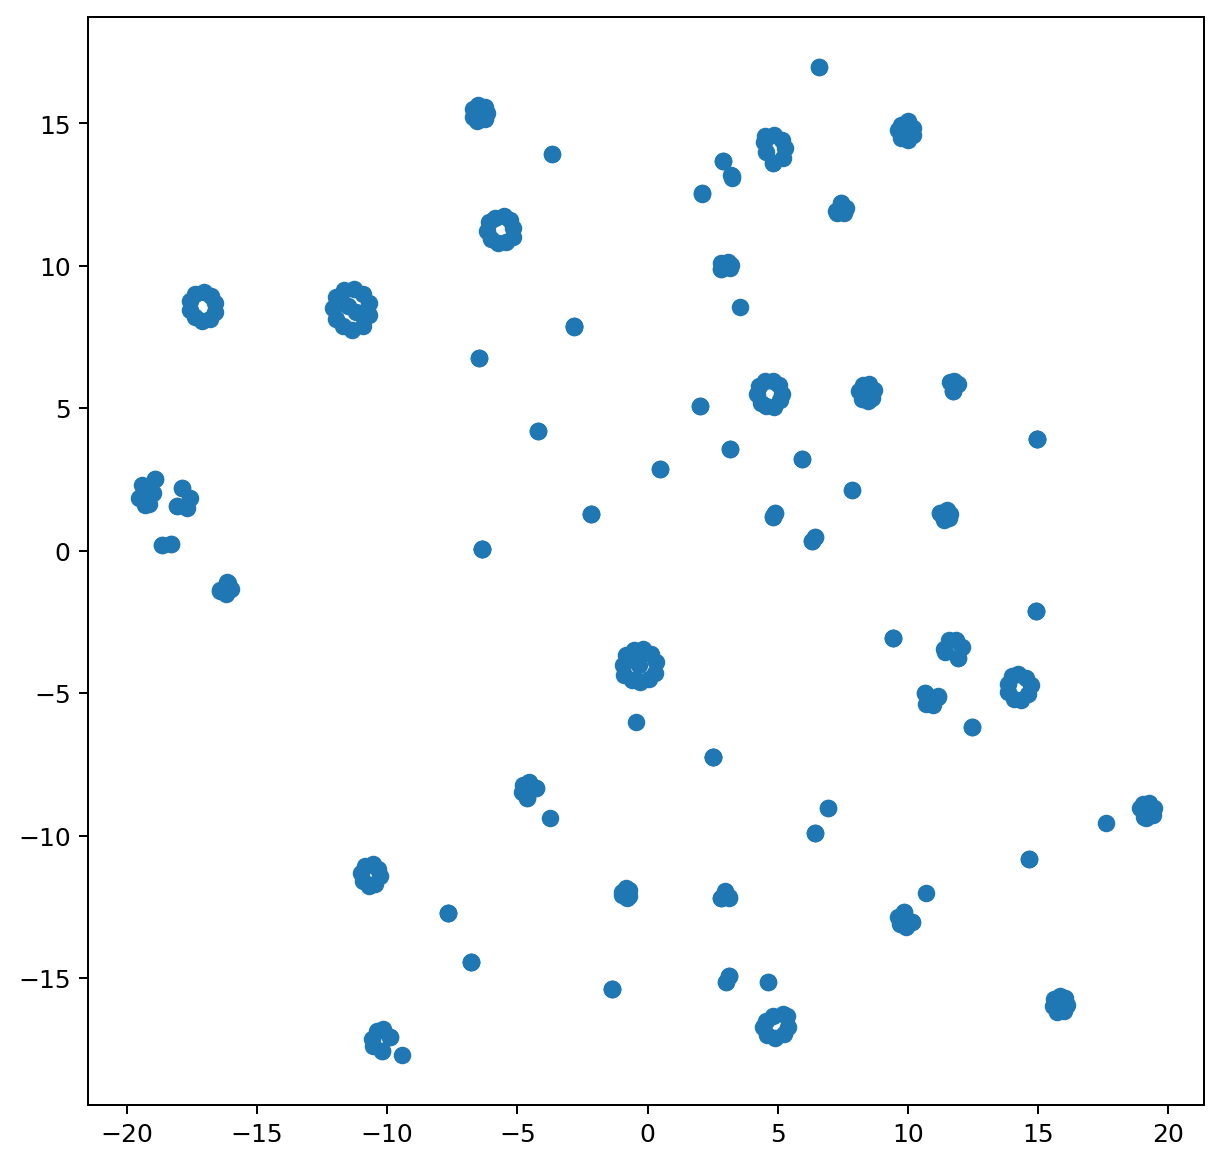

In [ ]:
from sklearn.manifold import TSNE

plt.figure(figsize=(8, 8), dpi=180)
reduced = TSNE().fit_transform(image_embeddings)
sample_indexes = np.random.choice(len(reduced), size=200, replace=False)
plt.scatter(reduced[:,0], reduced[:,1])
# width = 0.5
# for i in sample_indexes:
#     plt.imshow((np.moveaxis(images[i], 0, 2) + 2) / 2, extent=(reduced[i,0] - width / 2, reduced[i,0] + width / 2, reduced[i,1] - width / 2, reduced[i,1] + width / 2))
# plt.xlim(reduced[:,0].min(), reduced[:,0].max())
# plt.ylim(reduced[:,1].min(), reduced[:,1].max())
plt.show()